# Prediction of the quantity of taxi orders in time

# Content

1. [Project Description](#section_1)
2. [Data import and overview](#section_2)
3. [Data Analysis](#section_3)
4. [Models training](#section_4)
5. [Models testing](#section_5)

<a name = 'section_1'></a>
#  Project Description

Taxi company wants to understand what time is the highest and lowest drivers load for the optimization of the cost and increase of the drivers in a peak drivers load time. Based on the provided historical data from the company (taxi orders in airports) it's required  to predict the quantity of the orders in next hour.

Main tasks are:

1. Load the data and perform resampling to 1 hour.
2. Perform the data Analysis.
3. Train the models with different hypreparameters. The test samplpe shall be equal to 10% of all data.
4. Test the best model and draw a conclusion.
5. RMSE score on the best model shall not exceed 48.

<a name = 'section_2'></a>
# Data import and overview

Имортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

import warnings 
warnings.filterwarnings("ignore")

**Импортируем данные, ознакомимся с ними и проводеме ресэмплинг с периодом в 1 час**

In [2]:
data = pd.read_csv('taxi.csv',index_col = [0], parse_dates = [0])

In [3]:
data = data.sort_index()

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data = data.resample('1H').sum()

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<a name = 'section_3'></a>
# Data Analysis

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Plotting of graphs: destribution of orders, weekly and daily flatterned**

<AxesSubplot:xlabel='datetime'>

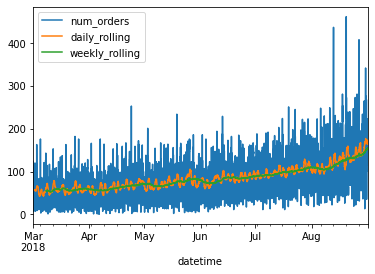

In [9]:
temp_data = data.copy()
temp_data['daily_rolling'] = temp_data.rolling(24).mean()
temp_data['weekly_rolling'] = temp_data['num_orders'].rolling(172).mean()
temp_data.plot()

**Trend and seasonality graphs plotting**

In [10]:
decomposed_data = seasonal_decompose(data)
decomposed_data_szn = seasonal_decompose(data.resample('1D').sum())

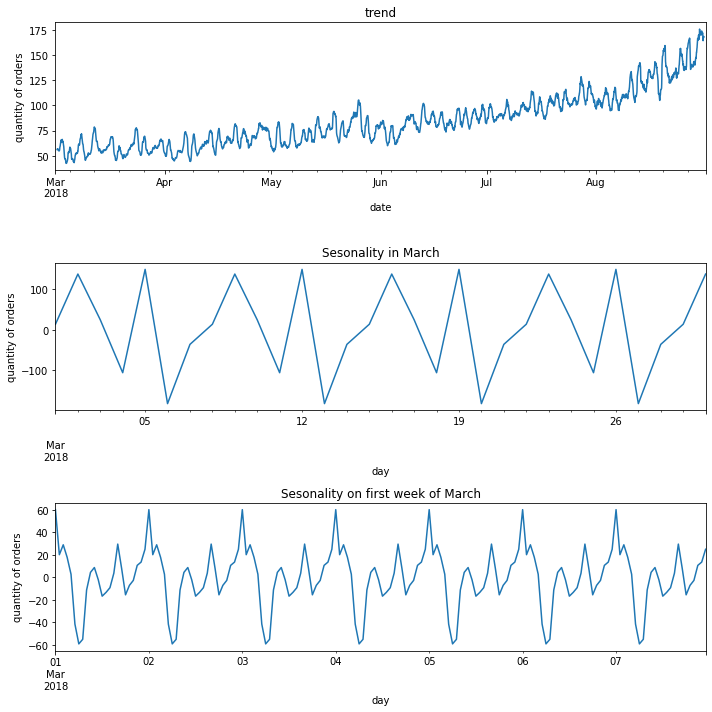

In [11]:
plt.figure(figsize =(10,10))
plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('trend')
plt.ylabel('quantity of orders')
plt.xlabel('date')

plt.subplot(312)
decomposed_data_szn.seasonal.head(30).plot(ax=plt.gca())
plt.title('Sesonality in March')
plt.ylabel('quantity of orders')
plt.xlabel('day')

plt.subplot(313)
decomposed_data.seasonal.head(168).plot(ax=plt.gca())
plt.title('Sesonality on first week of March')
plt.ylabel('quantity of orders')
plt.xlabel('day')

plt.tight_layout()

**Conclsuion:**

- Based on the analysis we see that deamnd on the taxi has slow groth  from March to end of August. 
- On the seasonal March graph we see increase of demand in the middle of the week and on weekends.
- On the season graph of first week of march we see that the highest demand is in the second half of the day and the lowest demand is the night.

<a name = 'section_4'></a>
# Models training

**Features extracting**

In [12]:
data['year'] = data.index.year

In [13]:
data['month'] = data.index.month

In [14]:
data['day'] = data.index.day

In [15]:
data['dayofweek'] = data.index.dayofweek

In [16]:
data['hour'] = data.index.hour

In [17]:
# function for adding the required qunatity of columns using shift method
def rol_lag(df,lag_num,rol_qty):
    df['rolling_mean'] = df['num_orders'].shift().rolling(rol_qty+1).mean()
    lag = 1
    for i in range(lag_num):
        df['lag'+str(lag)] = df['num_orders'].shift(i)
        lag+=1
    return(df)

In [18]:
data_set = rol_lag(data,3,5)
data_set = data_set.dropna()
data_set.head(10)

,num_orders,year,month,day,dayofweek,hour,rolling_mean,lag1,lag2,lag3
datetime,,,,,,,,,,
2018-03-01 06:00:00,12,2018,3,1,3,6,65.833333,12,6.0,43.0
2018-03-01 07:00:00,15,2018,3,1,3,7,47.166667,15,12.0,6.0
2018-03-01 08:00:00,34,2018,3,1,3,8,35.500000,34,15.0,12.0
2018-03-01 09:00:00,69,2018,3,1,3,9,29.333333,69,34.0,15.0
2018-03-01 10:00:00,64,2018,3,1,3,10,29.833333,64,69.0,34.0
2018-03-01 11:00:00,96,2018,3,1,3,11,33.333333,96,64.0,69.0
2018-03-01 12:00:00,30,2018,3,1,3,12,48.333333,30,96.0,64.0
2018-03-01 13:00:00,32,2018,3,1,3,13,51.333333,32,30.0,96.0
2018-03-01 14:00:00,48,2018,3,1,3,14,54.166667,48,32.0,30.0


In [19]:
train, test = train_test_split(data_set, shuffle = False, test_size = 0.1)

In [20]:
train, valid = train_test_split(train, shuffle = False, test_size = 0.2)

In [21]:
train_target = train['num_orders']
train_features = train.drop('num_orders', axis = 1)

In [22]:
valid_target = valid['num_orders']
valid_features = valid.drop('num_orders', axis = 1)

In [23]:
test_target = test['num_orders']
test_features = test.drop('num_orders', axis = 1)

**Logistic regression training**

In [24]:
LR_model = LogisticRegression(random_state=0)

In [25]:
LR_model.fit(train_features,train_target)

LogisticRegression(random_state=0)

In [26]:
LR_predictions = LR_model.predict(valid_features)

In [27]:
RMSE_LR = mean_squared_error(valid_target,LR_predictions,squared= False)

In [28]:
RMSE_LR

32.28852920756703

**Random forest training**

In [29]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 30, num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [30]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [31]:
RF = RandomForestRegressor()

In [32]:
tscv = TimeSeriesSplit(max_train_size = 5, test_size=1)

In [33]:
RF_model = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, random_state=42, cv=tscv)

In [34]:
RF_model.fit(train_features,train_target)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=5, n_splits=5, test_size=1),
                   estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 12, 14, 16, 18, 21,
                                                      23, 25, 27, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42)

In [35]:
RF_predictions = RF_model.predict(valid_features)

In [36]:
RMSE_RF = mean_squared_error(valid_target,RF_predictions,squared= False)

In [37]:
RMSE_RF

13.172828459572049

<a name = 'section_5'></a>
# Models testing

**selection of best model:**

In [38]:
list = [LR_model,RF_model]

In [39]:
result_df = pd.DataFrame(list,columns = ['model'])

In [40]:
prediction = []
test_rmse =[]
for i in range(len(list)):
    prediction.append(result_df['model'][i].predict(test_features))
    test_rmse.append(mean_squared_error(test_target,result_df['model'][i].predict(test_features),squared = False))
    
result_df['prediction'] = prediction
result_df['RMSE'] = test_rmse

In [41]:
result_df.sort_values(by = 'RMSE')

,model,prediction,RMSE
1,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[157.66814285714284, 145.987, 148.755492063492...",29.591714
0,LogisticRegression(random_state=0),"[129, 118, 129, 110, 146, 76, 115, 110, 129, 1...",58.060274


In [42]:
best_result = result_df['RMSE'].min()

In [43]:
best_model = result_df[result_df['RMSE'] == best_result]

In [44]:
best_model

,model,prediction,RMSE
1,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[157.66814285714284, 145.987, 148.755492063492...",29.591714


**Conclusion** 

1) Best RMSE score has random forest model with hyperparameters tuning;

2) required score RMSE < 48 sccessfully achieved